In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [13]:
# Загрузим файлы
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [14]:
train.head(5)

,ID,ЛПНП
0,k31__1__1,1
1,k31__5__5,0
2,k31__6__6,0
3,k31__17__17,0
4,k31__16__16,1


In [15]:
# Посмотрим на число положительных случаев
train['ЛПНП'].value_counts()

,count
ЛПНП,
1,330
0,223


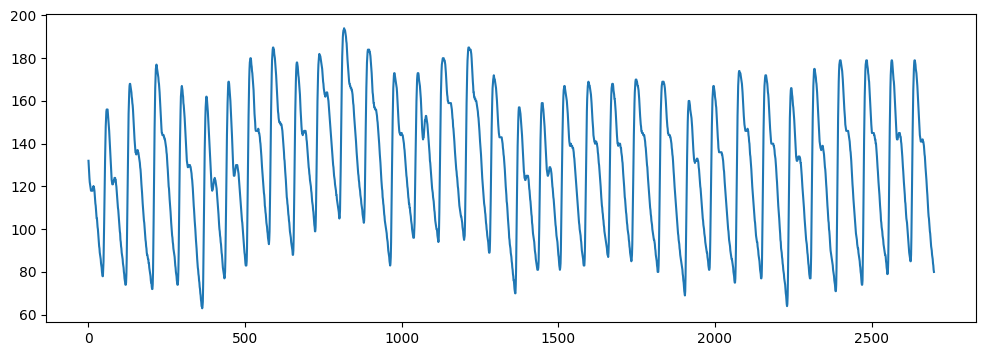

In [16]:
# Загрузим одну из фотоплетизмограмм
file_id = train.iloc[1]['ID']
path = 'ppgs/' + file_id + '.npy'
ppg = np.load(path)
plt.figure(figsize=(12,4))
plt.plot(ppg)

In [17]:
# Разделим обучающую выборку на обучающую и валидационную часть
train, val = train_test_split(train, test_size=0.2, stratify=train['ЛПНП'], random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [18]:
# Создадим датасет
class PPGDataset(Dataset):
    def __init__(self, df, target_col='ЛПНП', training=True):
        """
        Параметры:
            df (DataFrame): Pandas DataFrame с метаданными
            target_col (str): Название колонки с целевой переменной ('ЛПНП')
            training (bool): Флаг - тренировочный режим или нет (влияет на возвращаемые значения)
        """
        self.data = df
        self.target_col = target_col
        self.training = training
        self.fs = 100

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Загрузка и обработка одного образца данных по индексу

        Возвращает:
            Для тренировочного режима: (ppg_signal, target)
            Для тестового режима: (ppg_signal, file_id)
        """
        row = self.data.iloc[idx]
        file_id = row['ID']

        path = f'ppgs/{file_id}.npy'
        ppg = np.load(path)

        b, a = signal.butter(3, [0.8 / self.fs, 5 / self.fs], 'bandpass')
        ppg = signal.filtfilt(b, a, ppg)

        ppg = ppg[:128*20]

        ppg = torch.tensor(ppg.copy(), dtype=torch.float32).view(1, -1)

        if self.training:
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return {'ppg': ppg, 'target': target}
        return {'ppg': ppg, 'file_id': file_id}

In [19]:
# Используемая нейронная сеть
class PPG_RNN_1D(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2,  number_of_classes=1):
        super(PPG_RNN_1D, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.fc = nn.Linear(hidden_size, number_of_classes)

        self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def _initialize_weights(self, method='xavier'):
        init_funcs = {
            'xavier': nn.init.xavier_normal_,
            'he': lambda w: nn.init.kaiming_normal_(w, nonlinearity='tanh'),
            'default': lambda w: None
        }
        init_func = init_funcs.get(method, init_funcs['default'])
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if method != 'default':
                    init_func(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



    def forward(self, x):
        x = x.permute(0, 2, 1)
        rnn_out, _ = self.rnn(x)
        out = rnn_out[:, -1, :]
        out = self.fc(out)
        return out

In [20]:
# Вспомогательная функция оценки
def evaluate(model, loss_function, data_loader, device):
    model.eval()
    true_labels = []
    pred_scores = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            ppg = data['ppg'].to(device)
            target = data['target'].to(device).float()

            if ppg.dim() == 4:
                ppg = ppg.squeeze()
            elif ppg.dim() == 3 and ppg.shape[-1] != 1:
                ppg = ppg.view(ppg.shape[0], ppg.shape[1], -1)

            outputs = model(ppg)

            loss_value = loss_function(outputs.squeeze(), target.squeeze())
            total_loss += loss_value.item() * ppg.size(0)

            true_labels.append(target.detach().cpu())
            pred_scores.append(torch.sigmoid(outputs.detach().cpu()))

    total_loss /= len(data_loader.dataset)
    true_labels_cat = torch.cat(true_labels)
    pred_scores_cat = torch.cat(pred_scores)

    return true_labels_cat, pred_scores_cat, total_loss

In [21]:
# Функция для обучения модели
def train_ppg_model(model, train_loader, val_loader, loss_function,
                    optimizer, epochs, scheduler=None, metric=None, device='cuda'):

    train_losses, val_losses, val_aucs = [], [], []

    model.to(device)

    best_auc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_metric_value = 0.0

        for data in train_loader:
            ppg = data['ppg'].to(device)
            target = data['target'].to(device).float()

            optimizer.zero_grad()
            outputs = model(ppg)

            loss_value = loss_function(outputs.view(-1), target.view(-1))
            loss_value.backward()
            optimizer.step()

            train_loss_epoch += loss_value.item() * ppg.size(0)

        train_loss_epoch /= len(train_loader.dataset)

        val_true, val_pred, val_loss_epoch = evaluate(
            model, loss_function, val_loader, device
        )

        try:
            val_auc_score = roc_auc_score(val_true.numpy(), val_pred.numpy())
        except ValueError:
            val_auc_score = 0.5

        if val_auc_score > best_auc:
            best_auc = val_auc_score
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val AUC: {val_auc_score:.4f}")

        if scheduler is not None:
            scheduler.step(val_auc_score)
            current_lr = scheduler.get_last_lr()[0]
            print(f"Learning rate after epoch {epoch+1}: {current_lr}")

        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
        val_aucs.append(val_auc_score)

    return train_losses, val_losses, val_aucs, best_model_state

In [22]:
# Объявление параметров и обучение
BATCH = 10
EPOCHS = 100
LR = 2.5e-05

train_dataset = PPGDataset(train, training=True)
val_dataset = PPGDataset(val, training=True)
test_dataset = PPGDataset(test, training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

model = PPG_RNN_1D(number_of_classes=1)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_function = nn.BCEWithLogitsLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

history_losses_train, history_losses_val, history_aucs_val, best_model_state = train_ppg_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device
)

Epoch 1/100, Train Loss: 0.6884, Val Loss: 0.6841, Val AUC: 0.6128
Epoch 2/100, Train Loss: 0.6850, Val Loss: 0.6808, Val AUC: 0.6003
Epoch 3/100, Train Loss: 0.6827, Val Loss: 0.6778, Val AUC: 0.5939
Epoch 4/100, Train Loss: 0.6808, Val Loss: 0.6766, Val AUC: 0.5912
Epoch 5/100, Train Loss: 0.6795, Val Loss: 0.6743, Val AUC: 0.6003
Epoch 6/100, Train Loss: 0.6785, Val Loss: 0.6718, Val AUC: 0.6145
Epoch 7/100, Train Loss: 0.6777, Val Loss: 0.6713, Val AUC: 0.6114
Epoch 8/100, Train Loss: 0.6772, Val Loss: 0.6703, Val AUC: 0.6182
Epoch 9/100, Train Loss: 0.6763, Val Loss: 0.6701, Val AUC: 0.6017
Epoch 10/100, Train Loss: 0.6758, Val Loss: 0.6688, Val AUC: 0.6081
Epoch 11/100, Train Loss: 0.6754, Val Loss: 0.6677, Val AUC: 0.6088
Epoch 12/100, Train Loss: 0.6751, Val Loss: 0.6680, Val AUC: 0.6081
Epoch 13/100, Train Loss: 0.6745, Val Loss: 0.6688, Val AUC: 0.5929
Epoch 14/100, Train Loss: 0.6746, Val Loss: 0.6697, Val AUC: 0.5764
Epoch 15/100, Train Loss: 0.6743, Val Loss: 0.6674, Val A

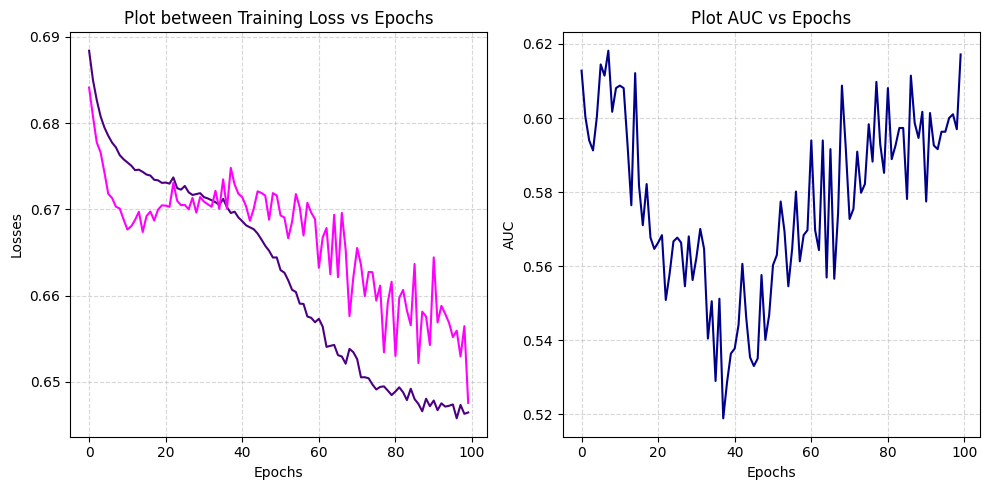

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history_losses_train, color='indigo')
ax1.plot(history_losses_val, color='magenta')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses')
ax1.set_title('Plot between Training Loss vs Epochs')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2.plot(history_aucs_val, color='darkblue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Plot AUC vs Epochs')
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [24]:
model.load_state_dict(best_model_state)
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for data in test_loader:
        ppg = data['ppg'].to(device)
        file_id = data['file_id']
        outputs = model(ppg).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        test_preds.extend(probs)
        test_ids.extend(file_id)

# Создадим датафрейм
result_df = pd.DataFrame({
    'ID': test_ids,
    'ЛПНП': test_preds
})
test_predictions = test.merge(result_df, on='ID', how='left')

In [25]:
# Убедимся, что датафрейм с предсказаниями, имеет нужный формат
test_predictions.head()

,ID,ЛПНП
0,k31__2__2,0.678924
1,k31__0__0,0.632660
2,k31__13__13,0.596417
3,k31__14__14,0.636239
4,k31__25__25,0.554991


In [26]:
# Сохраним датафрейм с предсказаниями
test_predictions.to_csv('submit3.csv', index=False)